# Load data

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Tuple, List, Callable

In [55]:
def load_file(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Loads the data from the file stored at :param path: and returns the 
    input values and the class labels.
    :param path: path of a CVS file with data
    :return: a tuple containing the input matrix of shape (n, p) and a line 
    vector with the m class labels in {0, ..., 9}
    """
    # citire date sin fisierul dat de path
    df = pd.read_csv(path, header=None)
    X = df[df.columns[1:]].T
    y = df[df.columns[0]].to_frame().T
    assert X.ndim ==  2, 'Matrix required for input values'
    assert y.ndim == 2, 'Column matrix required for labels'
    assert y.shape == (1, X.shape[1]), 'Same number of lines is required'
    return X, y

In [56]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

In [57]:
X_train, y_train = load_file(path_train)
assert X_train.shape == (784, 60000)
assert y_train.shape == (1, 60000)

X_test, y_test = load_file(path_test)
assert X_test.shape == (784, 10000)
assert y_test.shape == (1, 10000)

In [58]:
def scale_values(X: np.ndarray) -> np.ndarray:
    """Scales the values to range [0, 1].
    :param X: an (m, n) matrix with values between 0 and 255.
    :return: an (m, n) matrix containing values of :param X: scaled in [0, 1]
    """
    result = np.array(X) / 255
    assert 0 <= np.min(result) <= np.max(result) <= 1, 'Scaled values should be in [0, 1]'
    assert X.shape == result.shape, 'Scaling preserves shape'
    return result

In [59]:
X_train = scale_values(X_train)
assert X_train.shape == (784, 60000)
X_test = scale_values(X_test)
assert X_test.shape == (784, 10000)

# Create model

## Define model's architecture

In [60]:
m = 10 # number of classes
n, p = X_train.shape
architecture = [n, 100, m] # list: [input_size, hidden1, hidden2, ..., output_size]

assert len(architecture) >= 3, 'At least one hidden layer'
assert architecture[0] == n
assert architecture[-1] == m

Ponderile sunt initializate conform strategiei lui Xavier Glorot. Pentru o matrice de ponderi $W^{[l]}$ de forma $n_{l} \times n_{l-1}$, ponderile pot fi initializate cu o distributie uniforma in intervalul 
$$
\left[-\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}, +\frac{\sqrt{6}}{\sqrt{n_{l} + n_{l-1}}}\right]
$$

Ponderile de bias se obisnuiesc a se initializa cu 0; intializarea aleatoare a ponderilor W este considerata suficienta pentru a obtine spargerea simetriei.

Ref: [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

In [61]:
def create_weights(architecture: List[int], init_type:str='glorot_uniform') -> Tuple[List[np.array], List[np.array]]:
    """Creates the list of weights and biases for the given architecture.
    :param architecture: list of number of nodes in each layer 
    (including input and ouotput layers)
    :param init_type: name of initialization parameter. Defaults to 
    'glorot_uniform', add other supported initializtion strategies.
    :return: a tuple containing: list of weight matrices W, a list of bias 
    column vectors. The two lists have the same numer of elements, number of 
    layers - 1.
    """
    L = len(architecture)
    W, b = [], []
    # initializare de ponderi
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        W.append(np.random.uniform(- np.sqrt(6)/np.sqrt(nl + n_lplus1), np.sqrt(6)/np.sqrt(nl + n_lplus1), (n_lplus1, nl)))
    for n_l in architecture[1:]:
        b.append(np.vstack(np.repeat(0, n_l)))
    assert len(W) == len(b) == L-1
    for i, w in enumerate(W):
        assert w.shape == (architecture[i+1], architecture[i]), f'Shape of W[{i}] should be (L[{i+1}], L[{i}])'
    for i, _b in enumerate(b):
        assert _b.shape == (architecture[i+1], 1), f'Shape of b[{i}] should be (L[{i+1}], 1)'
    if init_type == 'glorot_uniform':
        for i, w in enumerate(W):
            w_shape_sum = np.sum(w.shape)
            assert -np.sqrt(6)/np.sqrt(w_shape_sum) <= np.min(w) <= np.sqrt(6)/np.sqrt(w_shape_sum), f"Values of W[{i}] should be according to Glorot's initialization"
        for i, _b in enumerate(b):
            assert 0 == np.min(_b) == np.min(_b) == 0, f"Values of b[{i}] should be initialized to 0"
    return W, b

Activation functions:
- Logistic sigmoid:
$$f = \sigma : \mathbb{R} \rightarrow (0, 1), f(z) = \sigma(z) = \frac{1}{1 + \exp{(-z)}}$$
and its derivative:
$$f'(z) = \sigma'(z) = \sigma(z)(1 - \sigma(z)) = f(z) \cdot (1 - f(z))$$
- Hyperbolic tangent:
$$f = \tanh : \mathbb{R} \rightarrow (-1, 1), f(z) = \tanh(z) = \frac{\exp(z) - \exp(-z)}{\exp(z) + \exp(-z)}$$
and its derivative:
$$f'(z) = \tanh'(z) = 1 - \tanh^2(z) = 1 - f^2(z)$$
- Rectified Linear Unit (ReLU):
$$f(x) = \max(0, x) = \begin{cases} 0 & \text{if } x \leq 0 \\ x & \text{if } x > 0 \end{cases}$$
and its derivative:
$$f'(x) = \begin{cases} 0 & \text{if } x \leq 0 \\ 1 & \text{if } x > 0 \end{cases}$$

In [62]:
def sigmoid(z: np.array) -> np.array:
    """Computes sigmoid activation function"""
    return 1/1+np.exp(-z)

def derivative_sigmoid(z: np.array) -> np.array:
    """Computes the derivatives for the sigmoid activation function"""
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z: np.array) -> np.array:
    """Computes the tanh activation function"""
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def derivative_tanh(z: np.array) -> np.array:
    """Computes the derivatives for the tanh activation function"""
    return 1 - tanh(z)**2

def ReLU(z: np.array) -> np.array:
    """Computes the rectified linear unit activation function"""
    return (z > 0) * z 

def derivative_ReLU(z: np.array) -> np.array:
    """Computes the derivatives of the rectified linear unit activation function"""
    return np.heaviside(z, 0) # one-liner of thr = 0, z[z <= 0] = 0, z[z == 0] = thr, z[z > 0] = 1

In [92]:
def softmax(z, axis=0):
    """Applies softmax to a matrix z.
    :param z: np.array of shape (m, k)
    """
    max_z = np.max(z, axis=axis, keepdims=True)
    exp_z = np.exp(z-max_z)
    sum_exp_z = np.sum(np.exp(z-max_z), axis=axis, keepdims=True)
    result = exp_z/sum_exp_z
    assert np.allclose(np.sum(result, axis=axis), 1.0)
    return result
def derivative_softmax(z):
    """Computes the deriative of the softmax function."""
    return softmax(z)*(1 - softmax(z))

In [93]:
W, b = create_weights(architecture=architecture)

## Feedforward propagation

In [81]:
def can_multiply(a:np.array, b:np.array) -> bool:
    return a.ndim == b.ndim == 2 and a.shape[1] == b.shape[0]

def can_multiply_hadamard(a:np.array, b:np.array) -> bool:
    return a.shape == b.shape

Formulele 6.18 - 6.21 din curs:
$$\Large \textbf{a}^{(1)} = \textbf{x}$$
$$\Large \textbf{z}^{(l)} = \textbf{W}^{(l-1)} \cdot \textbf{a}^{(l-1)} + \textbf{b}^{(l-1)}$$
$$\Large \textbf{a}^{(l)} = f^{(l)}(\textbf{z}^{(l)}), f^{(l)}(\cdot), l = 2, ..., L$$
$$\Large \textbf{o} = \textbf{a}^{(L)}$$

In [82]:
def model(X:np.array, W:List[np.array], b:List[np.array], f:List[Callable]) -> (np.array, np.array):
    """Computes the output produced by the MLP for the given input X
    :param X: np.array of shape (n, p). Each column of X is a datum from a set.
    :param W: a list of weight matrices
    :param b: a list of bias columns
    :param f: a list of activation functions
    :return: a matrix of output values produced by MLP, of shape: number of 
    predicted outputs (e.g. classes), number of input vectors p
    """
    Z = []
    A = []
    assert len(W) == len(b) == len(f)
    p = X.shape[1]
    a = X
    A.append(a)
    for i, (_w, _b, _f) in enumerate(zip(W, b, f)):
        # variabila i poate fi folosita pentru debug
        assert can_multiply(_w, a)
        z = _w @ a + _b
        Z.append(z)
        assert z.shape == (_w.shape[0], p)
        a = _f(z)
        A.append(a)
        assert a.shape == z.shape
    assert a.shape == (W[-1].shape[0], p)
    return a, Z, A

In [83]:
# f[0] = functia de activare pe primul strat ascuns; 
# f[1] = functia de activare pe al doilea strat ascuns etc.
f = [sigmoid, softmax]
y_hat, _, _ = model(X_train, W, b, f)

assert y_hat.shape == (m, p)
assert np.allclose(y_hat.sum(axis=0), np.ones(p))

## Error function

$$\Large J(\textbf{W}, \textbf{b}) = - \sum_{i=1}^p \sum_{j=1}^m d_j^{(i)} \log o_j^{(i)} + \frac{\lambda}{2} \sum_{l=1}^{L-1} \left\lVert \textbf{W}^{(l)} \right\rVert_F^2$$

In [84]:
def J(X, y, W, b, f, num_classes=10, _lambda=0.01):
    """Computes the error function for MLP
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k)
    :param W: list pf MLPs weights
    :param b: list pf MLPs biases
    :return: loss values, composed of cross entropy + penalty term
    """
    p = X.shape[1]
    EPS = 1e-5
    # computes a one hot encoding for the given classes:
    # if y[i]=c, 0 <= c <= 9 (here), then column i in one_hot_encoding is filled
    # in with 0, excepting line c where one finds value 1
    y_ohe = np.zeros((num_classes, p))
    y_ohe[y, np.arange(y_ohe.shape[1])] = 1
    assert np.all(y_ohe.sum(axis=0) == 1)
    predicted, _, _ = model(X, W, b, f)
    predicted = np.clip(predicted, EPS, 1-EPS)
    loss1 = -np.sum(y_ohe * np.log(predicted))
    W_frobenius_norms = [np.linalg.norm(w, ord='fro') for w in W]
    loss2 = _lambda/2 * np.sum(W_frobenius_norms)
    return loss1 + loss2

In [85]:
def accuracy(X:np.array, y:np.array, W: List[np.array], b: List[np.array], f:List[Callable]) -> float:
    """Computes the accuracy on a given input dataset X, with ground truth y
    :param X: np.array of shape (n, k)
    :param y: np.array of shape (1, k); each value is the index of a class
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activation functions. the last one must be softmax
    :return: ratio between correctly classified vectors and total number of cases
    """
    p = X.shape[1]
    y_hat, _, _ = model(X, W, b, f)
    y_ohe = np.zeros((10, p))
    y_ohe[y, np.arange(y_ohe.shape[1])] = 1
    y_predicted = np.zeros_like(y_hat)
    y_predicted[y_hat.argmax(axis=0), np.arange(y_hat.shape[1])] = 1
    return (np.logical_and(y_predicted == y_ohe, y_ohe == 1)).sum() / X.shape[1]

# Train model

In [101]:
def backpropagation(architecture: List[int], X: np.array, d: np.array, W: List[np.array], b:List[np.array], num_classes, _lambda:float, alpha:float):
    DW, Db = [], []
    fderiv = [derivative_sigmoid, derivative_softmax]
    for n_lplus1, nl in zip(architecture[1:], architecture[:-1]):
        DW.append(np.zeros((n_lplus1, nl)))
    for n_l in architecture[1:]:
        Db.append(np.vstack(np.repeat(0, n_l)))
    p = X.shape[1]
    L = len(architecture)
    
    for digit in range(0, p):
        d_ohe = np.zeros((num_classes, 1))
        d_ohe[d[digit], 0] = 1
        o_ohe, Z, A = model(X[:,digit].reshape(-1,1), W, b, f)
        delta = []
        
        delta.append(-(d_ohe - o_ohe) * fderiv[L-2](Z[L-2]))
        
        for l in range(L-2, 0, -1):
            delta.append((W[l].T @ delta[L-2-l]) * fderiv[l](Z[l-1]))
        
        dJdW, dJdb = [], []
        for l in range(0, L-2):
            dJdW.append(delta[L-2-l] @ A[l].T)
            dJdb.append(delta[L-2-l])

        for l in range(0, L-2):
            DW[l] = DW[l] + dJdW[l]
            Db[l] = Db[l] + dJdb[l]

        for l in range(0, L-2):
            W[l] = W[l] - alpha * ((1/p * DW[l]) + _lambda * W[l])
            b[l] = b[l] - alpha * (1/p * Db[l])
        
        if digit % 1000 == 0:
            print(f"DIGIT: {digit}")
    return W, b

In [102]:
def train(architecture: List[int], X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array, num_classes, W: List[np.array], b:List[np.array], f:List[Callable], _lambda: float, alpha: float, max_delta_error:float=1e-4) -> Tuple[List[np.array], List[np.array], List[float], List[float], List[float]]:
    """Runs the training on the training dataset (X, y). Stops when  
    difference between  two succesive error values is lower than :param max_delta_error:
    :param X_train: np.array of shape (n, k), with training cases. Each column is a training case
    :param y_train: np.array of shape (1, k), containing labels (0=class 0, ...)
    :param X_test: np.array of shape (n, l), with test cases. Each column is a test vector
    :param y_test: np.array of shape (1, l), containing labels (0=class 0, ...)
    :param num_classes: number of classes
    :param W: list of MLP's weights
    :param b: list of MLP's biases
    :param f: list of activations functions; the last one must be softmax
    :param _lambda: coefficient >= for the L2 penalty term
    :param alpha: > 0, learning rate
    :max_delta_error: >0, a threshold for max absolute difference of succesive loss values
    :return: a tuple consisting of: list of weight matrices, list of biases, list of errors computed at each epoch on training set, 2 lists of accuracies on training and on test set at each epoch
    """
    errors = [J(X_train, y_train, W, b, f, num_classes, _lambda)]
    acc_train = [accuracy(X_train, y_train, W, b, f)]
    acc_test = [accuracy(X_test, y_test, W, b, f)]
    epoch = 0
    p = X_train.shape[1]
    while True:
        epoch += 1
        W, b = backpropagation(architecture, X_train, y_train, W, b, num_classes, _lambda, alpha)
        # actualizare ponderi si biases W, b pentru fiecare pereche de date din setul de instruire *_test
        error = J(X_train, y_train, W, b, f, num_classes, _lambda)
        errors.append(error)
        train_acc = accuracy(X_train, y_train, W, b, f)
        acc_train.append(train_acc)
        test_acc = accuracy(X_test, y_test, W, b, f)
        acc_test.append(test_acc)
        ##if epoch % 10 == 0: TO UNCOMMENT!!!!!
        print(f'Epoch: {epoch}, error: {error}, train accuracy: {train_acc}, test accuracy: {test_acc}')
        if np.abs(errors[-1] - errors[-2]) < max_delta_error:
            break
        # plot de valore de eroare pe train si pe test
    return W, b, errors, train_acc, test_acc

In [103]:
W, b = create_weights(architecture)

W, b, errors, acc_train, acc_test = train(architecture, X_train, y_train, X_test, y_test, 10, W, b, f, 0.01, 0.5)

DIGIT: 0
DIGIT: 1000
DIGIT: 2000
DIGIT: 3000
DIGIT: 4000
DIGIT: 5000


KeyboardInterrupt: 

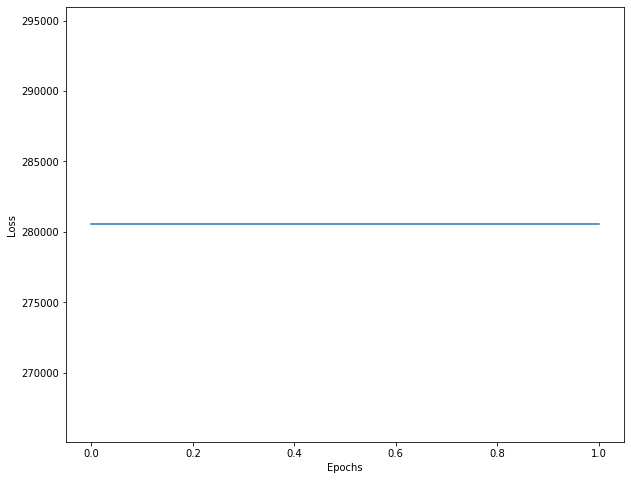

In [88]:
plt.figure(figsize=(10, 8))
plt.plot(errors, label='Loss on train DS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
# acc_train, acc_test
plt.plot(acc_train, label='Acc train')
plt.plot(acc_test, label='Acc test')

# Test model

In [ ]:
print(f'Accuracy on test set: {accuracy(X_test, y_test, theta)}')